In [1]:
from erddapy import ERDDAP

server = "https://opendap.co-ops.nos.noaa.gov/erddap"

e = ERDDAP(server=server, protocol="tabledap")

The `dataset_id` can be found by searching the server with the `get_search_url` or with the browser.

In [2]:
dataset_id = "IOOS_Hourly_Height_Verified_Water_Level"

e.dataset_id = dataset_id

We can check what is in the dataset with ERDDAP's `info` URL.

In [3]:
import pandas as pd


info_url = e.get_info_url(dataset_id=dataset_id, response="csv")

info = pd.read_csv(info_url)
info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,cdm_data_type,String,TimeSeries
1,attribute,NC_GLOBAL,cdm_timeseries_variables,String,"STATION_ID,BEGIN_DATE,END_DATE"
2,attribute,NC_GLOBAL,Conventions,String,"COARDS, CF-1.6, ACDD-1.3"
3,attribute,NC_GLOBAL,featureType,String,TimeSeries
4,attribute,NC_GLOBAL,geospatial_lat_units,String,degrees_north


The variables are:

In [4]:
set(info["Variable Name"])

{'BEGIN_DATE',
 'DATUM',
 'END_DATE',
 'I',
 'L',
 'NC_GLOBAL',
 'SIGMA',
 'STATION_ID',
 'WL_VALUE',
 'latitude',
 'longitude',
 'time'}

This server have some `REQUIRED` variables for each request to get a valid URL,

In [5]:
info.loc[info["Value"].astype(str).str.startswith("REQUIRED")]

,Row Type,Variable Name,Attribute Name,Data Type,Value
19,attribute,STATION_ID,long_name,String,REQUIRED 7-character Station ID surrounded in ...
36,attribute,DATUM,long_name,String,REQUIRED 3- to 4-character Datum surrounded in...
41,attribute,BEGIN_DATE,long_name,String,REQUIRED 8- to 14-character Begin Date (yyyymm...
45,attribute,END_DATE,long_name,String,REQUIRED 8- to 14-character End Date (yyyymmdd...


and the time has its own special format.

In [6]:
pd.set_option("max_colwidth", 100)

info.loc[info["Variable Name"] == "END_DATE"]["Value"]

42                                                                                  NaN
43                                                                       Up to one year
44                                                                                 Time
45    REQUIRED 8- to 14-character End Date (yyyymmdd hh:mi) surrounded in double quotes
Name: Value, dtype: object

[With most ERDDAP servers](https://ioos.github.io/erddapy/) we can pass the time constraint as any valid time string or a python object, this dataset requites `yyyymmdd` for some reason :-/

Also, because this dataset has some required variables, and the time constraints does not work here, we must pass the actual variable values as constraints.

In [7]:
e.constraints = {
    "BEGIN_DATE=": "20140801",
    "END_DATE=": "20140901",
    "DATUM=": "MLLW",
    "STATION_ID=": "8570283",
}

url = e.get_download_url()

print(url)

https://opendap.co-ops.nos.noaa.gov/erddap/tabledap/IOOS_Hourly_Height_Verified_Water_Level.html?&BEGIN_DATE="20140801"&END_DATE="20140901"&DATUM="MLLW"&STATION_ID="8570283"


We can request the data from that URL as netCDF, CSV, JSON, etc. B/c it is a time-series let's request a `csv` and put it in a pandas `DataFrame` via the `to_pandas` method.

In [8]:
df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
).dropna()


# Make it a naive time zone for plotting.
df.index = df.index.tz_localize(None)

df.head()

,STATION_ID,latitude (degrees_north),longitude (degrees_east),DATUM,BEGIN_DATE,END_DATE,WL_VALUE (meters),SIGMA,I,L
time (UTC),,,,,,,,,,
2014-08-01 00:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.404,0.013,0,0
2014-08-01 01:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.547,0.012,0,0
2014-08-01 02:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.650,0.016,0,0
2014-08-01 03:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.729,0.014,0,0
2014-08-01 04:00:00,8570283,38.3283,-75.0917,MLLW,20140801,20140901,0.738,0.016,0,0


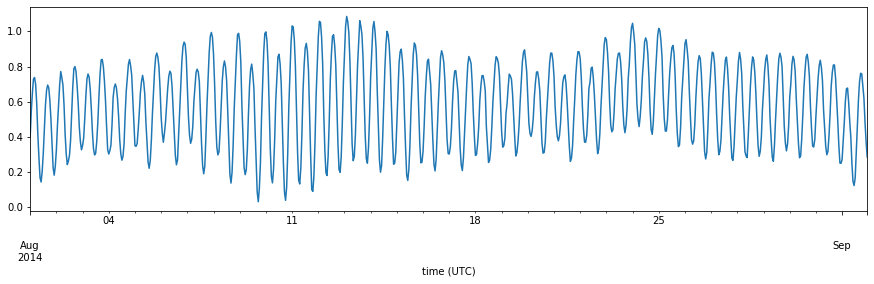

In [9]:
%matplotlib inline


df["WL_VALUE (meters)"].plot(figsize=(15, 3.75));